# WATER BAG PREDICTION - Model Selection

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample, groupSplitGridSearch
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

#### Imbalanced preprocessing & learning modules
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#### Preprocessing & machine learning modules
from sklearn.utils import all_estimators
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.model_selection import cross_validate, GridSearchCV

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

#### Metrics and scoring functions
from sklearn.metrics import (
    make_scorer, recall_score, precision_score,
    f1_score, precision_recall_fscore_support,
    classification_report as cr
)

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-1': f1_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

In [3]:
def split_report(Y, yt, ye):
    cnts = [yt.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nTrain folder'); display(pd.concat(cnts, 1))
    cnts = [ye.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nValidation folder'); display(pd.concat(cnts, 1))

    eval_size = len(ye) / len(Y) * 100
    eval_minority = (ye==1).sum() / (Y==1).sum() * 100
    train_minority = (ye==0).sum() / (Y==0).sum() * 100
    eval_stats = pd.DataFrame(
        [eval_size, train_minority, eval_minority],
        ['Samples left', 'Negative Samples left', 'Positive Samples left'],
        ['Validation (%)'],
    ).round(2)
    display(eval_stats)

from sklearn.metrics import precision_recall_curve

def precision_recall_plot(ye, yprob):
    
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    
    curve['f1 - 1'] = curve.mean(1)
    prec, rec = curve['precision - 1'], curve['recall - 1']
    curve['harmonic mean - 1'] = 2 * prec * rec / (prec + rec)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
    curve.plot(ax=ax[0]); curve.reset_index().plot('recall - 1', ['precision - 1', 'threshold', 'f1 - 1', 'harmonic mean - 1'], ax=ax[1])
    ax[0].set(title='Threshold-Moving Performance')
    ax[1].set(title='Precision Recall Curve')

    return ax

def precision_recall_plot_report(model, xe, ye, threshold=None, flat_score=False):
    
    try: yprob = model.predict_proba(xe)[:, 1]
    except:
        try: yprob = model.decision_function(xe)
        except: yprob = model.predict(xe)
    yprob = pd.Series(yprob, index=xe.index)
    
    ax = precision_recall_plot(ye, yprob); plt.show()
    if threshold is None:
        threshold = float(input('Select decision threshold:'))
        
    yhat = (yprob >= threshold).astype('int')
    scr = pd.DataFrame(
        precision_recall_fscore_support(ye, yhat),
        index=['precision', 'recall', 'f1', 'support']
    ).T
    display(scr)

    if flat_score:
        scr = pd.concat([scr.loc[label].add_suffix('-' + str(label)) for label in [0, 1]], 0)
    return scr, threshold

#### Grid search classification score visualization function

def classifier_scr_grid_plot(scr_grid, figsize=(14, 4), share_y=True, param_name='param_gbc__n_estimators', ax_params={}):
    fig, ax = plt.subplots(1, 2, True, share_y, figsize=figsize)
    train_cols = ['mean_train_precision-1', 'mean_train_recall-1', 'mean_train_f1-1']
    test_cols = ['mean_test_precision-1', 'mean_test_recall-1', 'mean_test_f1-1']
    scr_grid.set_index(param_name)[train_cols].plot(ax=ax[0])
    scr_grid.set_index(param_name)[test_cols].plot(ax=ax[1])
    for axe in ax: axe.set(**ax_params)
    plt.show()

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---
# Feature and target selection

### Feature set

In [5]:
train_start, train_end = '2018-06', '2021-10'
eval_start, eval_end = '2021-11', '2022-04'

transform_args = dict(
    scale=True, interpolate='nearest', fillna='mean'
)

# Select feature set
X = TimeseriesTransformPipeline(
    data, train_start, cut=-1,
    drop_empty_cols=True,
    **transform_args,
); X = X[: eval_end]

# Validation split
xt = X[:train_end]
xe = X[eval_start: eval_end]

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


### Target variable

In [6]:
target_id = Yi.columns[2]
periods_ahead = 4

print(f'Modeling target {target_names[int(target_id)]} - id: {target_id}', '\n')

# Select target
Y = Yi[str(target_id)].loc[X.index].copy()
display(Y.value_counts().to_frame('Target'))

# Group target positive class labels by being consecutive in time (group evaluation strategy)
groups = groupConsecutiveFlags(ts=Y)

### Target transformation
if periods_ahead is not None:
    Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
    groups = groupConsecutiveFlags(ts=Y)
    display(Y.value_counts().to_frame('Transformed Target'))

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

### Validation statistics ---
split_report(Y, yt, ye)

Modeling target Rua do Catete - id: 1 



,Target
0.0,136496
1.0,783


,Transformed Target
0.0,136282
1.0,997



Train folder


,Class Count,Class Count
0.0,119037,0.992777
1.0,866,0.007223



Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


,Validation (%)
Samples left,12.66
Negative Samples left,12.65
Positive Samples left,13.14


### Minority Group split Undersample - Group target positive observations by being consecutive

In [7]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=0.79, test_size=0.20, # Not used if minority split strategy is GroupKFold
    train_prct=None, test_prct='natural',
    random_state=0,
)

# Train data group shuffle split
cv_kfold = list(splitter.split(
    xt, yt, groups_train,
    strategy='GroupKFold'
)); print_cls_cnt(yt, cv_kfold[0][0], cv_kfold[0][1])

,Train set,Test set
Class,,
0.0,95119,23917
1.0,692,174


### Model definition

In [8]:
dummy = classifiers['DummyClassifier']
logistic = classifiers['LogisticRegression']
lda = classifiers['LinearDiscriminantAnalysis']
SVC = classifiers['SVC']
LinearSVC = classifiers['LinearSVC']
tree = classifiers['DecisionTreeClassifier']
gbc = classifiers['GradientBoostingClassifier']
rfc = classifiers['RandomForestClassifier']
abc = classifiers['AdaBoostClassifier']
# knn = classifiers['KNeighborsClassifier']
bgg = classifiers['BaggingClassifier']

models = [
    dummy(), logistic(), lda(),
    SVC(), LinearSVC(), tree(),
    gbc(n_estimators=25), rfc(n_estimators=25),
    abc(n_estimators=25), bgg(n_estimators=25)
]

---
# Model comparison

In [9]:
main_metrics = ['mean_test_precision-1', 'mean_test_recall-1', 'mean_test_f1-1']

### Cross validation & grid search parameters

In [10]:
model = gbc(n_estimators=20, verbose=1, random_state=0)

steps = [('under', RandomUnderSampler(sampling_strategy=0.02)), ('model', model)]
pipe = Pipeline(steps=steps); print('\n', 'Pipeline steps:', '\n'); print(steps)

minor_prct = yt.mean() / (1 - yt.mean())

param_grid = {
    'model': models
}; print('\n', 'Parameter grid:', '\n'); print(param_grid)

grid_search = GridSearchCV(
    pipe, param_grid, scoring=scoring, cv=cv_kfold,
    n_jobs=-1, verbose=2, error_score='raise',
    return_train_score=True, refit=False
)


 Pipeline steps: 

[('under', RandomUnderSampler(sampling_strategy=0.02)), ('model', GradientBoostingClassifier(n_estimators=20, random_state=0, verbose=1))]

 Parameter grid: 

{'model': [DummyClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), SVC(), LinearSVC(), DecisionTreeClassifier(), GradientBoostingClassifier(n_estimators=25), RandomForestClassifier(n_estimators=25), AdaBoostClassifier(n_estimators=25), BaggingClassifier(n_estimators=25)]}


### Evaluate pipeline

In [11]:
grid_search = grid_search.fit(xt, yt)

scr_grid = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


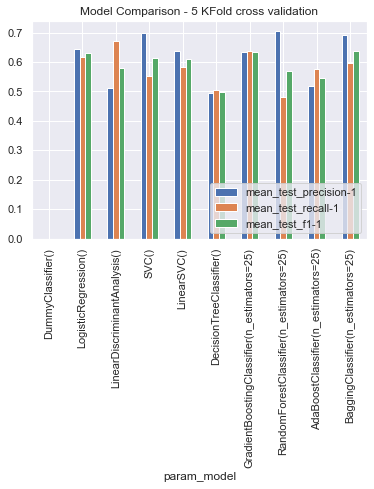

In [12]:
ax = scr_grid.plot.bar('param_model', main_metrics)
ax.legend(loc='lower right')
ax.set(title='Model Comparison - 5 KFold cross validation')
plt.show()

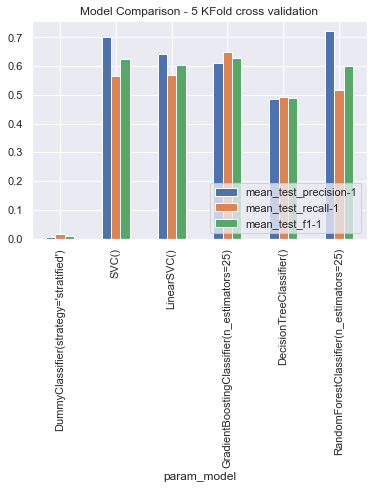

In [119]:
ax = scr_grid.plot.bar('param_model', main_metrics)
ax.legend(loc='lower right')
ax.set(title='Model Comparison - 5 KFold cross validation')
plt.show()

### Best model on validation data

Majority class percentage: .02


,Class Count
0.0,43300
1.0,866


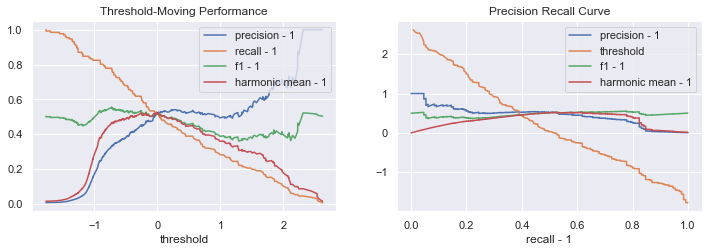

Select decision threshold: .5


,precision,recall,f1,support
0,0.995370,0.997333,0.996350,17245.0
1,0.525773,0.389313,0.447368,131.0


In [124]:
opt_prct = float(input('Majority class percentage:'))
rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0)

x_res, y_res = rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

model = SVC(C=.5)
model.fit(x_res, y_res) 

# scr_under, thresh = classifier_evaluation(LinearSVC(), x_res, y_res, xe, ye)
scr_under, thresh = precision_recall_plot_report(model, xe, ye)

---
# Class proportion optimization pipeline

Steps:
1. Tunning with cross validation on train data
1. Test optimal parameter on test data
1. Tunning with cross validation on train + test data (final model parameters)

Obs: It will be assumed that parameters found by tunning on train + validation data will work for novel data, as the ones found by tunning on train data worked for the validation data.

### Cross validation & grid search parameters

In [142]:
model = gbc(n_estimators=20, verbose=1, random_state=0)

steps = [('under', RandomUnderSampler()), ('model', model)]
pipe = Pipeline(steps=steps)

minor_prct = yt.mean() / (1 - yt.mean())

param_grid = {
    'under__sampling_strategy': loguniform(minor_prct, 0.06).ppf(np.linspace(0, 1, 6)),
}; print('Parameter Grid:'); print(param_grid)

grid_search = GridSearchCV(
    pipe, param_grid, scoring=scoring, cv=cv_kfold,
    n_jobs=-1, verbose=2, error_score='raise',
    return_train_score=True, refit=False
)

Parameter Grid:
{'under__sampling_strategy': array([0.00727505, 0.01109428, 0.01691851, 0.02580032, 0.03934488,
       0.06      ])}


### Evaluate pipeline

In [143]:
grid_search = grid_search.fit(xt, yt)

scr_grid = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


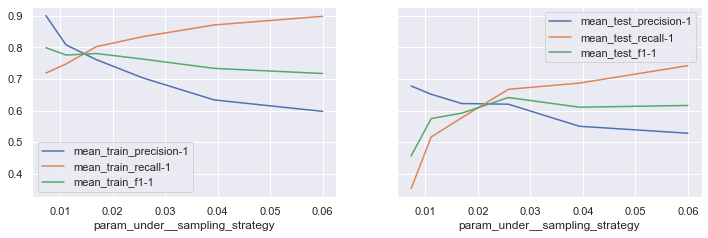

In [144]:
classifier_scr_grid_plot(scr_grid, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

### Optimal parameters on validation data

Majority class percentage: 0.02


,Class Count
0.0,43300
1.0,866


      Iter       Train Loss   Remaining Time 
         1           0.0891           13.89s
         2           0.0820           13.74s
         3           0.0768           12.91s
         4           0.0717           12.11s
         5           0.0680           11.42s
         6           0.0644           10.64s
         7           0.0610            9.86s
         8           0.0585            9.14s
         9           0.0556            8.39s
        10           0.0530            7.63s
        20           0.0383            0.00s


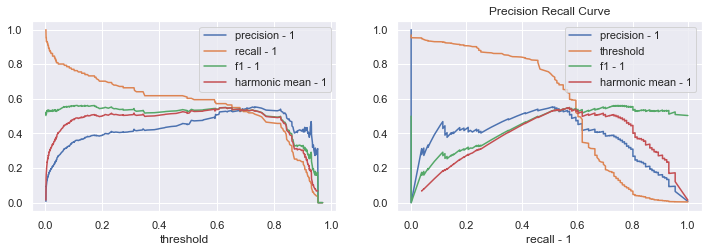

Select decision threshold: .5


,precision,recall,f1,support
0,0.996977,0.994491,0.995733,17245.0
1,0.454023,0.603053,0.518033,131.0


In [145]:
opt_prct = float(input('Majority class percentage:'))
rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0)

x_res, y_res = rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

### Bad parameters on validation data

Majority class percentage: 0.01


,Class Count
0.0,86600
1.0,866


      Iter       Train Loss   Remaining Time 
         1           0.0532           30.27s
         2           0.0503           28.46s
         3           0.0483           27.06s
         4           0.0465           25.44s
         5           0.0448           23.74s
         6           0.0427           22.22s
         7           0.0404           20.66s
         8           0.0383           19.06s
         9           0.0373           17.43s
        10           0.0360           15.86s
        20           0.0270            0.00s


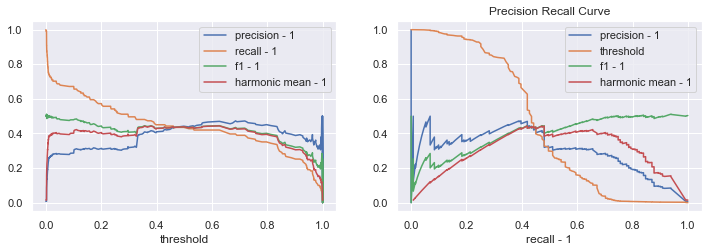

Select decision threshold: .5


,precision,recall,f1,support
0,0.995652,0.995825,0.995738,17245.0
1,0.437500,0.427481,0.432432,131.0


In [146]:
opt_prct = float(input('Majority class percentage:'))

rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0)
x_res, y_res = rus.fit_resample(xt, yt)

display(y_res.value_counts().to_frame('Class Count'))
scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

---
# Gradient Boosting hyperparameter tunning

### Cross validation & grid search parameters

In [149]:
model = gbc(n_estimators=20, verbose=1, random_state=0)

steps = [('under', RandomUnderSampler(.018)), ('model', model)]
pipe = Pipeline(steps=steps)

param_grid = {
    'model__loss': ['deviance', 'exponential'],    
    'model__learning_rate': [0.1, 0.2],
    'model__n_estimators': [25],
    'model__subsample': [0.6, 0.8, 1],
    'model__min_samples_split': [2, 3, 4],
    'model__max_depth': [None, 1, 2, 3, 4, 5],
    'model__init': [None, LinearSVC(max_iter=10000)]
}; print('Parameter Grid:'); print(param_grid)

grid_search = GridSearchCV(
    pipe, param_grid, scoring=scoring, cv=cv_kfold,
    n_jobs=-1, verbose=2, error_score='raise',
    return_train_score=True, refit=False
)

Parameter Grid:
{'model__loss': ['deviance', 'exponential'], 'model__learning_rate': [0.1, 0.2], 'model__n_estimators': [25], 'model__subsample': [0.6, 0.8, 1], 'model__min_samples_split': [2, 3, 4], 'model__max_depth': [None, 1, 2, 3, 4, 5], 'model__init': [None, LinearSVC(max_iter=10000)]}


### Evaluate pipeline

In [ ]:
grid_search = grid_search.fit(xt, yt)

scr_grid = pd.DataFrame(grid_search.cv_results_)

In [ ]:
classifier_scr_grid_plot(scr_grid, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

### Optimal parameters on validation data

Majority class percentage: .015


,Class Count
0.0,57733
1.0,866


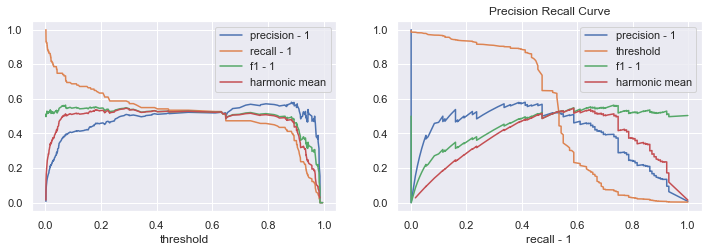

Select decision threshold: .5


,precision,recall,f1,support
0,0.996462,0.996289,0.996375,17245.0
1,0.522388,0.534351,0.528302,131.0


In [103]:
opt_prct = float(input('Majority class percentage:'))
rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0, replacement=False)

x_res, y_res = rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

### Bad parameters on validation data

Majority class percentage: .07


,Class Count
0.0,12371
1.0,866


      Iter       Train Loss   Remaining Time 
         1           0.3377            0.98s
         2           0.2915            0.74s
         3           0.2598            0.50s
         4           0.2347            0.25s
         5           0.2142            0.00s


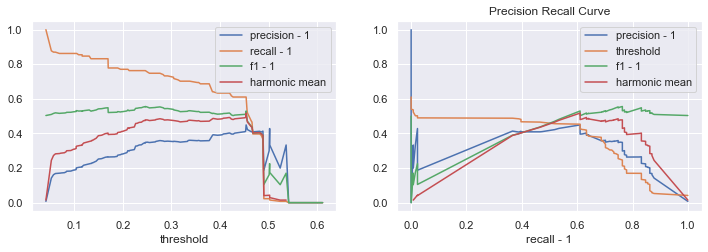

Select decision threshold: .5


,precision,recall,f1,support
0,0.992629,0.999594,0.996100,17245.0
1,0.300000,0.022901,0.042553,131.0


In [99]:
opt_prct = float(input('Majority class percentage:'))

rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0, replacement=False)
x_res, y_res = rus.fit_resample(xt, yt)

display(y_res.value_counts().to_frame('Class Count'))
scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

---
# Tunning class proportion and number of estimators

### Group split - Group target positive observations into consecutive

In [141]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=0.79, test_size=0.20, # Not used if minority split strategy is GroupKFold
    train_prct=None, test_prct='natural',
    random_state=0,
)

# Train data group shuffle split
cv_kfold = list(splitter.split(
    xt, yt, groups_train,
    strategy='GroupKFold'
)); print_cls_cnt(yt, cv_kfold[0][0], cv_kfold[0][1])

,Train set,Test set
Class,,
0.0,95119,23917
1.0,692,174


### Cross validation & grid search parameters

In [142]:
model = gbc(n_estimators=None, verbose=1, random_state=0)

steps = [('under', RandomUnderSampler()), ('model', model)]
pipe = Pipeline(steps=steps)

major_prct = (1 - yt.mean()) / yt.mean()

param_grid = {
    'under__sampling_strategy': loguniform(1 / major_prct, 0.075).ppf(np.linspace(0, 1, 12)),
    'model__n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 50]
}; print('Parameter Grid:'); print(param_grid)

grid_search = GridSearchCV(
    pipe, param_grid, scoring=scoring, cv=cv_kfold,
    n_jobs=-1, verbose=2, error_score='raise',
    return_train_score=True, refit=False
)

Parameter Grid:
{'under__sampling_strategy': array([0.00727505, 0.01109428, 0.01691851, 0.02580032, 0.03934488,
       0.06      ])}


### Evaluate pipeline

In [143]:
grid_search = grid_search.fit(xt, yt)

scr_grid = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


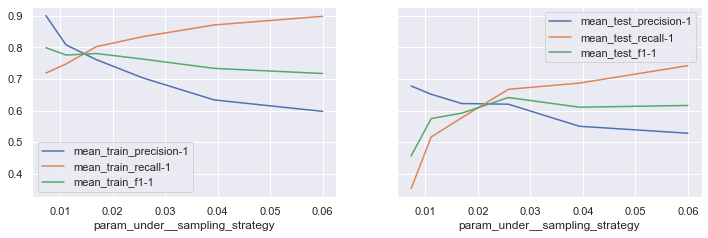

In [144]:
classifier_scr_grid_plot(scr_grid, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

### Optimal parameters on validation data

Majority class percentage: 0.02


,Class Count
0.0,43300
1.0,866


      Iter       Train Loss   Remaining Time 
         1           0.0891           13.89s
         2           0.0820           13.74s
         3           0.0768           12.91s
         4           0.0717           12.11s
         5           0.0680           11.42s
         6           0.0644           10.64s
         7           0.0610            9.86s
         8           0.0585            9.14s
         9           0.0556            8.39s
        10           0.0530            7.63s
        20           0.0383            0.00s


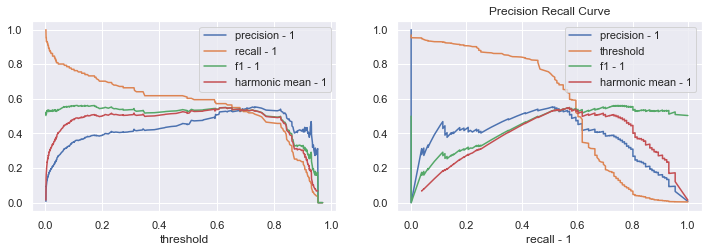

Select decision threshold: .5


,precision,recall,f1,support
0,0.996977,0.994491,0.995733,17245.0
1,0.454023,0.603053,0.518033,131.0


In [145]:
opt_prct = float(input('Majority class percentage:'))
rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0)

x_res, y_res = rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

### Bad parameters on validation data

Majority class percentage: 0.01


,Class Count
0.0,86600
1.0,866


      Iter       Train Loss   Remaining Time 
         1           0.0532           30.27s
         2           0.0503           28.46s
         3           0.0483           27.06s
         4           0.0465           25.44s
         5           0.0448           23.74s
         6           0.0427           22.22s
         7           0.0404           20.66s
         8           0.0383           19.06s
         9           0.0373           17.43s
        10           0.0360           15.86s
        20           0.0270            0.00s


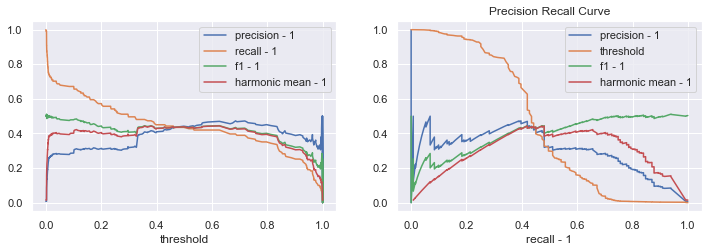

Select decision threshold: .5


,precision,recall,f1,support
0,0.995652,0.995825,0.995738,17245.0
1,0.437500,0.427481,0.432432,131.0


In [146]:
opt_prct = float(input('Majority class percentage:'))

rus = RandomUnderSampler(sampling_strategy=opt_prct, random_state=0)
x_res, y_res = rus.fit_resample(xt, yt)

display(y_res.value_counts().to_frame('Class Count'))
scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)